訓練集大小: 6432
測試集大小: 1608

GDA 模型參數計算完成:
Phi (φ): 0.4347
Mu_0 (μ₀): [121.00976073  23.60537954]
Mu_1 (μ₁): [120.97185622  23.74270386]
Sigma_0 (Σ₀):
[[ 0.45420498 -0.13506111]
 [-0.13506111  1.46482129]]
Sigma_1 (Σ₁):
[[0.17918027 0.18568671]
 [0.18568671 0.5815144 ]]

--- GDA 模型評估結果 ---
準確率 (Accuracy): 0.8302
分類報告 (Classification Report):
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       909
           1       0.83      0.77      0.80       699

    accuracy                           0.83      1608
   macro avg       0.83      0.82      0.83      1608
weighted avg       0.83      0.83      0.83      1608


--- 正在產生 GDA 決策邊界圖 ---


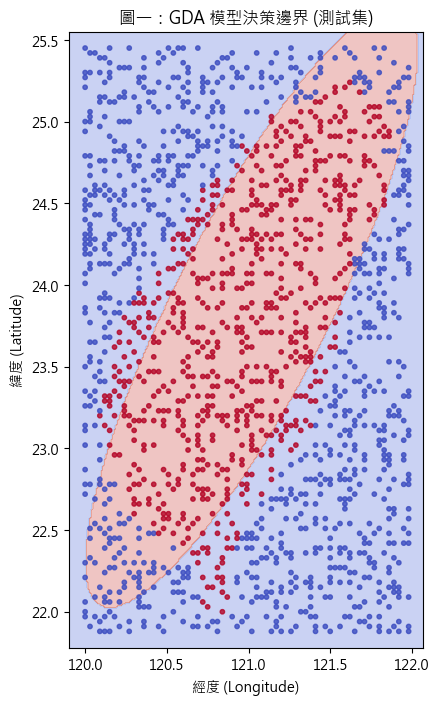


分類模型 C(x) - KNeighborsClassifier 訓練完成。
迴歸模型 R(x) - KNeighborsRegressor 訓練完成。

--- 正在產生分段函數 h(x) 的預測結果圖 ---


c:\Users\qian\anaconda3\envs\train\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\qian\anaconda3\envs\train\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


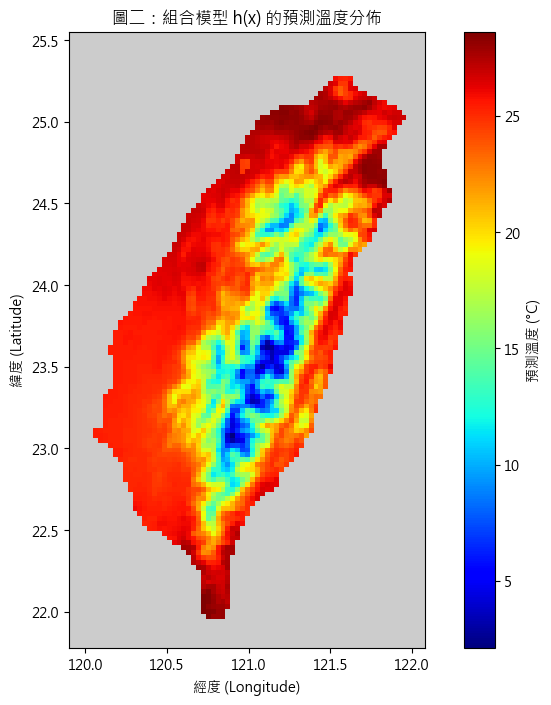

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 解決 Matplotlib 中文顯示問題
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Heiti TC', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False


# 讀取第四週產生的資料集
try:
    classification_df = pd.read_csv("classification_dataset.csv")
except FileNotFoundError:
    print("錯誤：找不到 classification_dataset.csv，請先執行第四週的資料轉換程式。")
    exit()

# 準備特徵 (X) 與目標 (y)
X = classification_df[['longitude', 'latitude']].values
y = classification_df['label'].values

# 分割訓練集與測試集 (80% 訓練, 20% 測試)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"訓練集大小: {X_train.shape[0]}")
print(f"測試集大小: {X_test.shape[0]}")


# 步驟 2-1: 計算 phi (類別 1 的先驗機率)
phi = (y_train == 1).mean()

# 步驟 2-2: 計算 mu_0 和 mu_1 (各類別的平均值向量)
mu_0 = X_train[y_train == 0].mean(axis=0)
mu_1 = X_train[y_train == 1].mean(axis=0)

# 步驟 2-3: 計算各類別自己的共變異數矩陣 Sigma_0 和 Sigma_1
sigma_0 = np.cov(X_train[y_train == 0].T)
sigma_1 = np.cov(X_train[y_train == 1].T)

print("\nGDA 模型參數計算完成:")
print(f"Phi (φ): {phi:.4f}")
print(f"Mu_0 (μ₀): {mu_0}")
print(f"Mu_1 (μ₁): {mu_1}")
print(f"Sigma_0 (Σ₀):\n{sigma_0}")
print(f"Sigma_1 (Σ₁):\n{sigma_1}")

def GDA_predict(X, phi, mu_0, mu_1, sigma_0, sigma_1):
    # 預先計算逆矩陣和行列式
    try:
        sigma_0_inv = np.linalg.inv(sigma_0)
        sigma_1_inv = np.linalg.inv(sigma_1)
        det_sigma_0 = np.linalg.det(sigma_0)
        det_sigma_1 = np.linalg.det(sigma_1)
    except np.linalg.LinAlgError:
        print("錯誤：共變異數矩陣是奇異的，無法計算逆矩陣。")
        return np.full(X.shape[0], 1 if phi > 0.5 else 0)

    # 避免 log(0) 或負數
    if det_sigma_0 <= 0 or det_sigma_1 <= 0:
        print("警告：行列式非正，無法計算 log。")
        return np.full(X.shape[0], 1 if phi > 0.5 else 0)

    # 計算每個點屬於類別 0 的分數
    diff_0 = X - mu_0
    term1_0 = -0.5 * np.einsum('ij,jk,ik->i', diff_0, sigma_0_inv, diff_0)
    term2_0 = -0.5 * np.log(det_sigma_0)
    term3_0 = np.log(1 - phi) if (1 - phi) > 0 else -np.inf
    score_0 = term1_0 + term2_0 + term3_0

    # 計算每個點屬於類別 1 的分數
    diff_1 = X - mu_1
    term1_1 = -0.5 * np.einsum('ij,jk,ik->i', diff_1, sigma_1_inv, diff_1)
    term2_1 = -0.5 * np.log(det_sigma_1)
    term3_1 = np.log(phi) if phi > 0 else -np.inf
    score_1 = term1_1 + term2_1 + term3_1
    
    # 比較分數，分數較高者為預測類別
    return (score_1 > score_0).astype(int)


# 在測試集上進行預測
y_pred_GDA = GDA_predict(X_test, phi, mu_0, mu_1, sigma_0, sigma_1)

# (c) 報告準確率
print("\n--- GDA 模型評估結果 ---")
print(f"準確率 (Accuracy): {accuracy_score(y_test, y_pred_GDA):.4f}")
print("分類報告 (Classification Report):\n", classification_report(y_test, y_pred_GDA, zero_division=0))


# (d) 繪製決策邊界
print("\n--- 正在產生 GDA 決策邊界圖 ---")

plt.figure(figsize=(8, 8))

# 建立網格點
lon_min, lon_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
lat_min, lat_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(lon_min, lon_max, 0.01),
                     np.arange(lat_min, lat_max, 0.01))

# 對網格上的每個點進行預測
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = GDA_predict(grid_points, phi, mu_0, mu_1, sigma_0, sigma_1)
Z = Z.reshape(xx.shape)

# 繪製決策邊界背景
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# 繪製測試集的資料點
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, s=10, alpha=0.8)

plt.title('圖一：GDA 模型決策邊界 (測試集)')
plt.xlabel('經度 (Longitude)')
plt.ylabel('緯度 (Latitude)')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


# =============================================================================
# Part 2: KNN 組合模型
# =============================================================================
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# 讀取第四週的資料集
try:
    classification_df = pd.read_csv("classification_dataset.csv")
    regression_df = pd.read_csv("regression_dataset.csv")
except FileNotFoundError:
    print("錯誤：找不到 CSV 檔案，請先執行第四週的資料轉換程式。")
    exit()

# (c) 組合函數說明:
# 1. C(x): 使用 KNeighborsClassifier 訓練一個分類模型，用於判斷觀測點是否有效。
# 2. R(x): 使用 KNeighborsRegressor 訓練一個迴歸模型，用於預測有效觀測點的溫度。
# 3. h(x): 結合兩者，對任意座標先用 C(x) 判斷，若有效則用 R(x) 預測溫度，否則回傳 -999。

# 準備分類模型的資料
X_class = classification_df[['longitude', 'latitude']]
y_class = classification_df['label']

# 準備迴歸模型的資料
X_reg = regression_df[['longitude', 'latitude']]
y_reg = regression_df['value']

# 訓練分類模型 C(x)
c_model = KNeighborsClassifier(n_neighbors=5)
c_model.fit(X_class, y_class)
print("\n分類模型 C(x) - KNeighborsClassifier 訓練完成。")

# 訓練迴歸模型 R(x)
r_model = KNeighborsRegressor(n_neighbors=5)
r_model.fit(X_reg, y_reg)
print("迴歸模型 R(x) - KNeighborsRegressor 訓練完成。")


def h(x_coords, c_model, r_model):
    """
    (a) 實作組合模型 h(x)
    """
    # 步驟 1: 使用分類模型 C(x) 進行預測
    c_pred = c_model.predict(x_coords)
    
    # 初始化結果陣列，預設為無效值 -999
    h_pred = np.full(c_pred.shape, -999.0)
    
    # 步驟 2: 找出預測為有效的點 (label=1)
    valid_mask = (c_pred == 1)
    valid_coords = x_coords[valid_mask]
    
    # 步驟 3: 如果存在有效點，則使用迴歸模型 R(x) 預測溫度
    if valid_coords.shape[0] > 0:
        r_pred = r_model.predict(valid_coords)
        h_pred[valid_mask] = r_pred
        
    return h_pred

# (b, d) 應用模型並視覺化結果
print("\n--- 正在產生分段函數 h(x) 的預測結果圖 ---")

# 建立與 GDA 視覺化時相同的網格
xx_h, yy_h = np.meshgrid(np.arange(lon_min, lon_max, 0.03),
                         np.arange(lat_min, lat_max, 0.03))
grid_points_h = np.c_[xx_h.ravel(), yy_h.ravel()]

# 使用 h(x) 進行預測
z_h = h(grid_points_h, c_model, r_model)
z_h = z_h.reshape(xx_h.shape)

# 繪製結果
plt.figure(figsize=(10, 8))

# 為了更好的視覺效果，我們將 -999 的部分用灰色表示
z_masked = np.ma.masked_where(z_h == -999, z_h)

# 繪製無效區域
plt.imshow(z_h == -999, extent=(lon_min, lon_max, lat_min, lat_max), origin='lower', cmap='gray_r', alpha=0.2)
# 繪製有效區域的溫度
im = plt.imshow(z_masked, extent=(lon_min, lon_max, lat_min, lat_max), origin='lower', cmap='jet', aspect='auto')

plt.title('圖二：組合模型 h(x) 的預測溫度分佈')
plt.xlabel('經度 (Longitude)')
plt.ylabel('緯度 (Latitude)')
plt.colorbar(im, label='預測溫度 (°C)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
